# Redes neurais convolucionais
Desenvolvimento de um modelo de rede neural convolucional (CNN) para a predição do tempo restante até evento de deslizamento/falha (terremoto).

## Conectando ao Google Drive

In [0]:
## Conectando o notebook com o Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Testando se o notebook acessa o Drive corretamente
!ls 'drive/' 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'My Drive'  'Shared drives'


In [0]:
#  Mover a pasta compartilhada para algum lugar em seu proprio drive, 
#  para conseguir acessar um atalho para o diretorio a partir daqui.

## Configurar essa variavel de ambiente (path_dados) para cada pessoa
## Meu caminho no drive (alexandre)
%env drv=drive/My Drive
%env proj=Aulas/2019_2/ie301-projeto/projeto

!ls "$drv/$proj/"
!echo "-------"
!ls .

env: drv=drive/My Drive
env: proj=Aulas/2019_2/ie301-projeto/projeto
dados  imagens	modelos  notebooks  submission-cnn.csv
-------
drive	     lista_modelos_cnn.pkl  __pycache__  sample_submission.csv
features.py  lista_modelos_lr.pkl   sample_data


## Importando bibliotecas

In [0]:
## Basic imports
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st

## Utils
import timeit
import time
from tqdm import tqdm
import pickle

## Audio features
# import librosa
# import librosa.display

Populating the interactive namespace from numpy and matplotlib


In [0]:
!cp "$drv/$proj/dados/sample_submission.csv" .
submission = pd.read_csv('sample_submission.csv')
submission.head()

,seg_id,time_to_failure
0,seg_00030f,0
1,seg_0012b5,0
2,seg_00184e,0
3,seg_003339,0
4,seg_0042cc,0


In [14]:
!ls "$drv/$proj/modelos/"

cnn-clas-over.pkl  lista_med_cnn.pkl	  lista_modelos_lr.pkl	 modelos-rf.pkl
cnn-clas.pkl	   lista_med_lr.pkl	  modelo-rf-50-full.pkl  resultados
cnn-regr.pkl	   lista_modelos_cnn.pkl  modelos-mlp-lr.pkl


In [0]:
## Carregando os modelos
!cp "$drv/$proj/modelos/lista_modelos_lr.pkl" .
!cp "$drv/$proj/modelos/lista_modelos_cnn.pkl" .
!cp "$drv/$proj/modelos/lista_med_lr.pkl" .
!cp "$drv/$proj/modelos/lista_med_cnn.pkl" .

with open('lista_modelos_lr.pkl', 'rb') as f:
    lista_modelos_lr = pickle.load(f)
    f.close()

with open('lista_modelos_cnn.pkl', 'rb') as f:
    lista_modelos_cnn = pickle.load(f)
    f.close()

with open('lista_med_lr.pkl', 'rb') as f:
    lista_med_lr = pickle.load(f)
    f.close()

with open('lista_med_cnn.pkl', 'rb') as f:
    lista_med_cnn = pickle.load(f)
    f.close()

## Funções auxiliares

In [0]:
def ajusta_distribuicao(y_orig, y_ref, y_range=np.arange(0, 10.5,.1), epsilon=1):
    """ ajusta_distribuicao(y_orig, y_ref, y_range, epsilon=1):

        Aplica o ajuste das medianas das distribuições encontradas
        no conjunto de treino, sobre um dado vetor de predições
        qualquer (treino, validação ou teste).
    """
    y_adj = np.copy(y_orig)
    for i in range(len(y_range)):
        val = y_range[i]
        idx = (y_orig >= val) & (y_orig < val+0.1)
        y_adj[idx] = y_adj[idx]*(1-epsilon) + y_ref[i]*epsilon
    return(y_adj)

## Experimento

In [0]:
### Keras (usando o backend TensorFlow)
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
# from keras.models import Model

# Layers
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.layers import Input

# Optimization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras.optimizers import Adam

# Regularization
from keras.regularizers import l2


In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
!cp "$drv/$proj/notebooks/utils/features.py" .
import features
import importlib
# importlib.reload(features)
feat_gen = features.FeatureGenerator()

In [79]:
## Gerando dataset
data_path = 'drive/My Drive/Aulas/2019_2/ie301-projeto/projeto/dados'
x_test = np.zeros([1,1500])

for i in tqdm(np.arange(submission.shape[0])):
    x_seg = pd.read_csv(data_path+'/test_downsampled/ds_' + submission.loc[i,'seg_id'] + '.csv')
    x_seg = x_seg.values.astype(float).reshape([1,1500])
    x_test = np.concatenate((x_test, x_seg), axis=0)
x_test = np.delete(x_test, 0, 0)
print(x_test.shape)


100%|██████████| 2624/2624 [00:27<00:00, 94.75it/s]

(2624, 1500)


In [80]:
## Gerando features
feats = feat_gen.gen_features(x_test)


  1%|          | 16/2624 [00:00<00:16, 158.81it/s]


Gerando features MFCC:



100%|██████████| 2624/2624 [00:16<00:00, 160.56it/s]


Gerando e adicionando features STAT ao DataFrame:
	 - Variância ...
	 - Curtose ...
	 - Quantil ...
	 - Threshold ...


In [0]:
## Resultados dos modelos
y_lr = np.zeros([3,2624]) 
y_cnn = np.zeros([3,2624]) 

for i in range(3):
    y_lr[i,:] = lista_modelos_lr[i].predict(feats['df_feats'])
    y_cnn[i,:] = lista_modelos_cnn[i].predict(x_test.reshape([-1, 1500, 1])).ravel()

y_lr[y_lr<0] = 0

y_lr_mean = y_lr.mean(axis=0)
y_cnn_mean = y_cnn.mean(axis=0)

In [0]:
## Ajustes dos modelos
y_lr_adj = np.zeros([3,2624]) 
y_cnn_adj = np.zeros([3,2624]) 

for i in range(3):
    y_lr_adj[i,:] = ajusta_distribuicao(y_lr[i,:], lista_med_lr[i], epsilon=0.5)
    y_cnn_adj[i,:] = ajusta_distribuicao(y_cnn[i,:], lista_med_cnn[i], epsilon=0.5)

y_lr_adj_mean = y_lr_adj.mean(axis=0)
y_cnn_adj_mean = y_cnn_adj.mean(axis=0)

y_comb = (y_lr_mean+y_cnn_mean)/2
y_comb_adj = (y_lr_adj_mean+y_cnn_adj_mean)/2

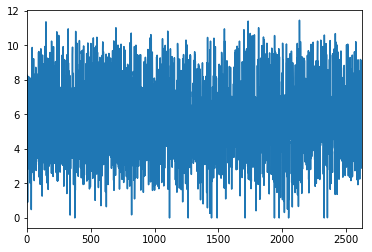

In [84]:
submission['time_to_failure'] = pd.Series(y_lr_mean)
submission['time_to_failure'].plot()
submission.to_csv('submission-final-lr.csv', index=False)
!cp 'submission-final-lr.csv' "$drv/$proj/"

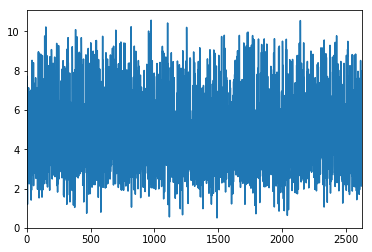

In [85]:
submission['time_to_failure'] = pd.Series(y_cnn_mean)
submission['time_to_failure'].plot()
submission.to_csv('submission-final-cnn.csv', index=False)
!cp 'submission-final-cnn.csv' "$drv/$proj/"

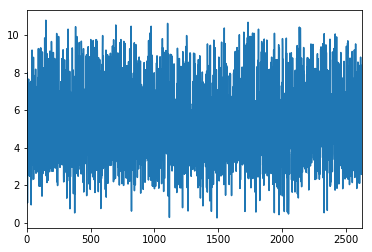

In [86]:
submission['time_to_failure'] = pd.Series(y_comb)
submission['time_to_failure'].plot()
submission.to_csv('submission-final-comb.csv', index=False)
!cp 'submission-final-comb.csv' "$drv/$proj/"

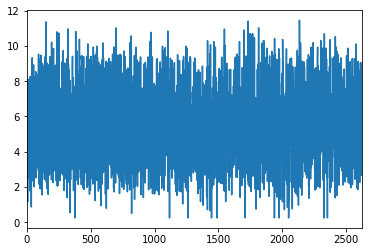

In [108]:
submission['time_to_failure'] = pd.Series(y_lr_adj_mean)
submission['time_to_failure'].plot()
submission.to_csv('submission-final-lr-adj.csv', index=False)
!cp 'submission-final-lr-adj.csv' "$drv/$proj/"

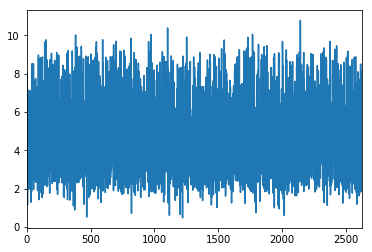

In [109]:
submission['time_to_failure'] = pd.Series(y_cnn_adj_mean)
submission['time_to_failure'].plot()
submission.to_csv('submission-final-cnn-adj.csv', index=False)
!cp 'submission-final-cnn-adj.csv' "$drv/$proj/"

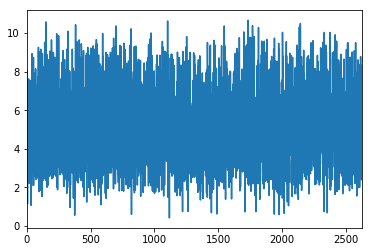

In [110]:
submission['time_to_failure'] = pd.Series(y_comb_adj)
submission['time_to_failure'].plot()
submission.to_csv('submission-final-comb-adj.csv', index=False)
!cp 'submission-final-comb-adj.csv' "$drv/$proj/"

In [111]:
sum(y_cnn_adj_mean==y_cnn_mean)

0